**Imports & Setup:**
---------------------

In [3]:
import sys
import cv2
import pandas as pd
import gc
import math
import random
import os
from PIL import Image
import time
from tqdm import tqdm_notebook as tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import *
from torchvision import models
from torch import nn
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
from torch.nn.modules.distance import PairwiseDistance
import torch.utils.model_zoo as model_zoo
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
from torch.nn.parameter import Parameter

In [5]:
# Set train path
train_path = '../tmp/class_train'
test_path = '../tmp/class_test'

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed_everything(42)

----------------

In [2]:
test_df = pd.read_csv('test_df.csv')
test_df.head()

,ImageId
0,004f40c73_0.png
1,004f40c73_1.png
2,004f40c73_2.png
3,004f40c73_3.png
4,004f40c73_0.png


--------------

**Load data:**
-------------------
* helper methods
* create dataset
* visualize example images

In [3]:
class SteelDataset(Dataset):
    def __init__(self, df, x_col, path):
        self.df = df
        self.x_col = x_col
        self.path = path
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # load image
        im_name = self.df[self.x_col].iloc[idx]
        img_path = f"{self.path}/{im_name}"
        img = cv2.imread(img_path)
        
        # normalize image
        img = img.astype(np.float32) / 255.0
        img = img - self.mean
        img = img / self.std
        
        # convert to torch tensors
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)
        
        #combine
        sample = {'image': img}
        return sample

In [4]:
steel_dataset = SteelDataset(test_df, 'ImageId',  test_path)

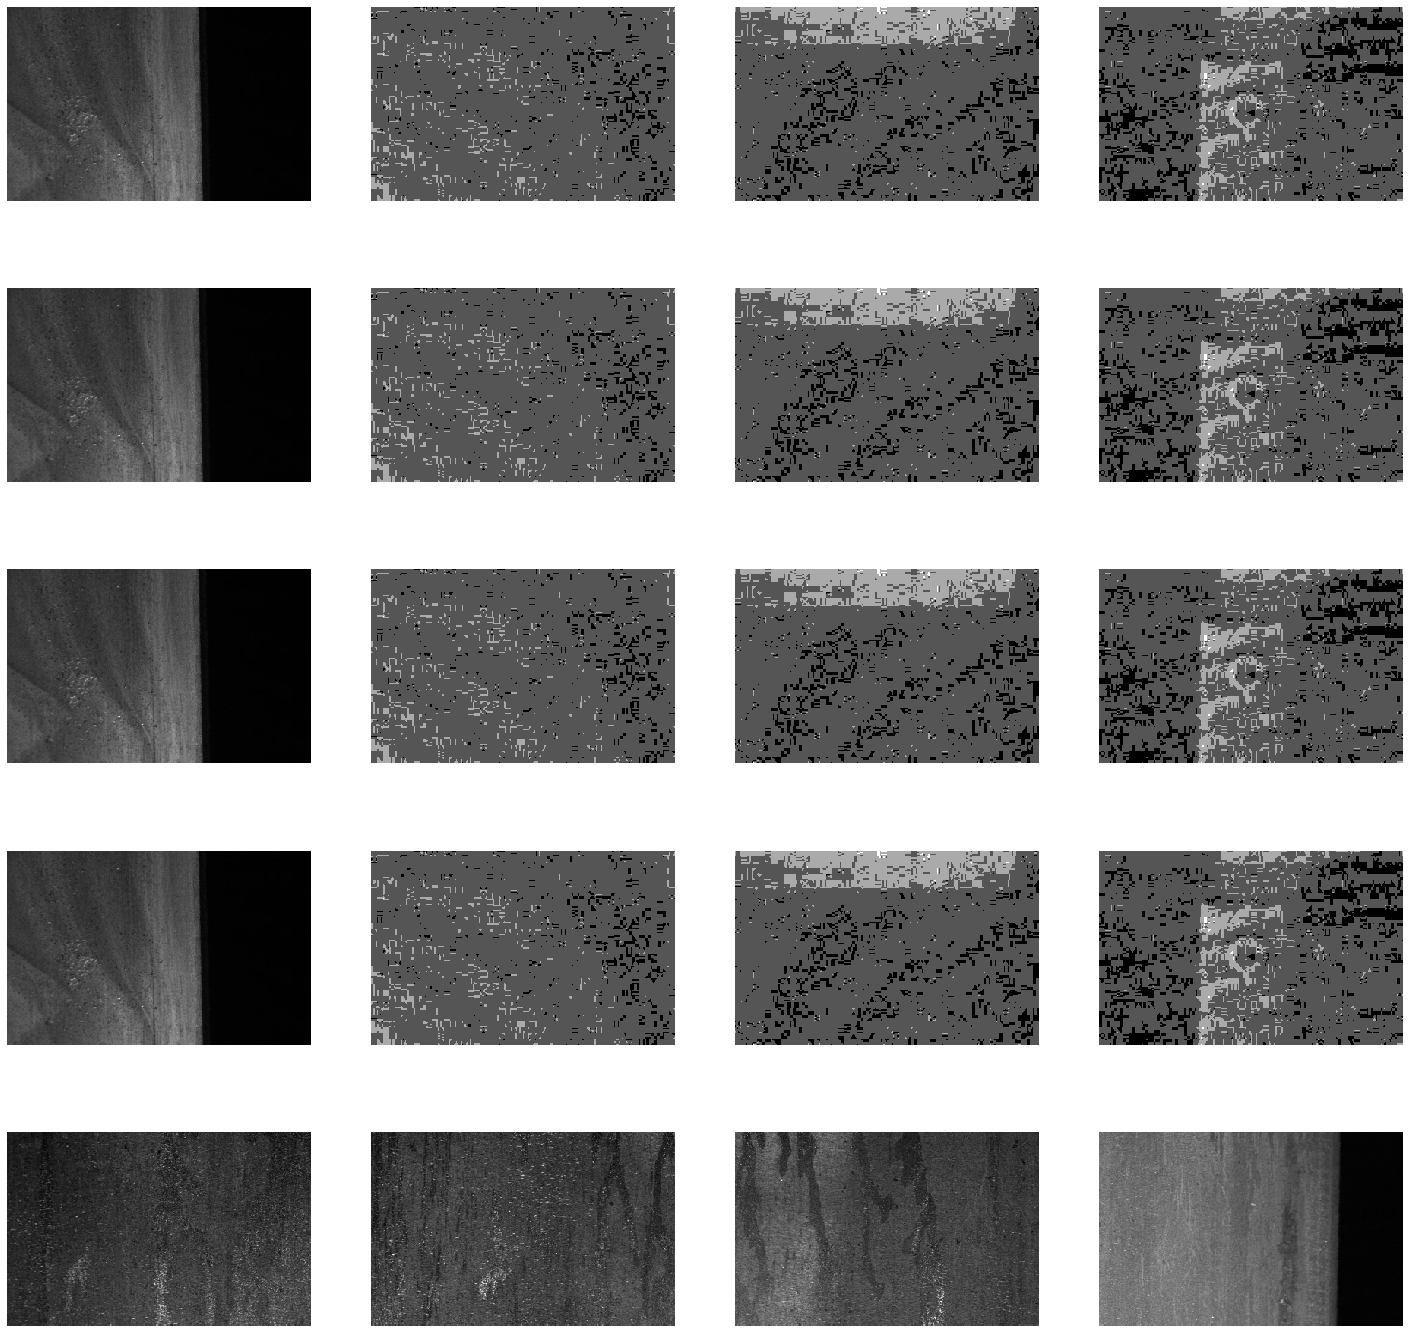

In [5]:
inc = 0
j = 0
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(25, 25), sharex=True)
for i in range(0,20,4):
    item1 = steel_dataset.__getitem__(i+inc)
    item2 = steel_dataset.__getitem__(i+inc+1)
    item3 = steel_dataset.__getitem__(i+inc+2)
    item4 = steel_dataset.__getitem__(i+inc+3)
    axs[j,0].imshow(item1['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,0].axis('off')
    axs[j,1].imshow(item2['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,1].axis('off')
    axs[j,2].imshow(item3['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,2].axis('off')
    axs[j,3].imshow(item4['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,3].axis('off')
    j+=1

In [6]:
# Parameters
params_test = {'batch_size': 16,
          'shuffle': False,
          'num_workers': 6}

test_generator = DataLoader(steel_dataset, **params_test)

-----------

**Load model:**
-------------------

In [7]:
class ArcFaceLoss(nn.modules.Module):
    def __init__(self,s=30.0,m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.classify_loss = nn.CrossEntropyLoss()
        self.s = s
        self.easy_margin = False
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, logits, labels):
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        loss1 = self.classify_loss(output, labels)
        loss2 = self.classify_loss(cosine, labels)
        gamma=1
        loss=(loss1+gamma*loss2)/(1+gamma)
        return loss

In [8]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features):
        super(ArcMarginProduct, self).__init__()
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        # nn.init.xavier_uniform_(self.weight)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight.cuda()))
        return cosine

In [9]:
class Net(nn.Module):

    def __init__(self, num_classes=5, EX=4):
        super(Net,self).__init__()
        self.EX = EX
        self.basemodel = torchvision.models.resnet50(pretrained=True)
        self.basemodel.avgpool = nn.AdaptiveAvgPool2d(1)
        self.basemodel.layer0 = nn.Sequential(self.basemodel.conv1,
                                              self.basemodel.bn1,
                                              self.basemodel.relu,
                                              self.basemodel.maxpool)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.arc_margin_product=ArcMarginProduct(512, num_classes)
        self.bn1 = nn.BatchNorm1d(1024 * self.EX)
        self.fc1 = nn.Linear(1024 * self.EX, 512 * self.EX)
        self.bn2 = nn.BatchNorm1d(512 * self.EX)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512 * self.EX, 512)
        self.bn3 = nn.BatchNorm1d(512)

    def forward(self, x, extract_feature = False):
        # basemodel
        x = self.basemodel.layer0(x)
        x = self.basemodel.layer1(x)
        x = self.basemodel.layer2(x)
        x = self.basemodel.layer3(x)
        x = self.basemodel.layer4(x)
        # new head
        x = torch.cat((nn.AdaptiveAvgPool2d(1)(x), nn.AdaptiveMaxPool2d(1)(x)), dim=1)
        x = x.view(x.size(0), -1)
        x = self.bn1(x)
        x = F.dropout(x, p=0.25)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = F.dropout(x, p=0.5)

        x = x.view(x.size(0), -1)

        x = self.fc2(x)
        feature = self.bn3(x)

        cosine=self.arc_margin_product(feature)
        if extract_feature:
            return cosine, feature
        else:
            return cosine

In [10]:
model = Net()
ckpt_path = "./class_model1.pth"
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
model.to(device)

Net(
  (basemodel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [11]:
preds = []
model.eval()
with torch.set_grad_enabled(False):
    for idx, minibatch in enumerate(tqdm(test_generator)):
        imgs = minibatch['image'].float()

        imgs = imgs.cuda()

        logits = model.forward(imgs, extract_feature = False)

        outputs = torch.argmax(logits,1)

        for i, output in enumerate(outputs):
            preds.append(output.data.to('cpu').numpy())

In [14]:
preds = np.array(preds).flatten()
rles = []
for i in range(0,len(preds),4):
    if sum(preds[i:i+4]) == 0:
        rles.append('')
    else:
        rles.append('1 1')

In [16]:
test_df = pd.read_csv('../input/severstal-steel-defect-detection/sample_submission.csv')
print(test_df.shape)
test_df.head()

(7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [17]:
test_df['EncodedPixels'] = rles
print(test_df.shape)
test_df.head(20)

(7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,
5,006f39c41.jpg_2,
6,006f39c41.jpg_3,
7,006f39c41.jpg_4,
8,00b7fb703.jpg_1,
9,00b7fb703.jpg_2,
